# Real-time Steps

In real-time mode, the FPGA lets Xylo run freely and only performs readout after receiving a timestep done interrupt.
This means sending input to Xylo from the FPGA is not supported in real-time mode.  Instead, the switches on the PCB must be configured such that Xylo receives input from the microphones on the PCB.


## Simple Samna example to access the board

In [4]:
ts_duration   = 10*1e-3; # in second
main_clk_freq = 50*1e6 # in Hz
tr_wrap       = int(ts_duration*main_clk_freq)
print(tr_wrap)

# 0: input for Xylo, 1: Xylo output
PDM_CLK_DIR  = 1
# 0: Xylo samples PDM_DATA at risinge edge, 1: Xylo samples PDM_DATA at falling edge
PDM_CLK_EDGE = 0

def get_tr_wrap(ts_in_ms, main_clk_freq_in_mhz, debug=0):
    ts_duration   = ts_in_ms*1e-3; # in second
    main_clk_freq = main_clk_freq_in_mhz*1e6 # in Hz
    tr_wrap       = int(ts_duration*main_clk_freq)
    print(f"set tr_wrap to 0x{format(tr_wrap,'_X')}") if debug>=1 else None
    return tr_wrap

500000


In [9]:
import samna
print(f"samna version: {samna.__version__}")
import time

device = samna.device.open_device('XyloAudio3TestBoard')

# set device configuration
ioc = device.get_io_control_module()
io = device.get_io_module()
model = device.get_model()

# power off
ioc.write_config(0, 0x0)
time.sleep(1)

# main clock disable
io.write_config(0x0008, 0)
time.sleep(1)

# power on
ioc.write_config(0, 0x1B)
time.sleep(1)

# main clock enable
io.write_config(0x0008, 1)
time.sleep(1)

# DIG_MIC drives PDM_DATA
io.write_config(0x0012, 0)
time.sleep(1)


# # set PDM clock
io.write_config(0x0027, 0)  # pdm clock msw
io.write_config(0x0028, 19)  # pdm clock lsw
io.write_config(0x0029, 1)  # FPGA pdm clock generation enabled
io.write_config(0x0026, 2)  # select: use pdm interface
# # bit 0: PDM_CLK edge (0: FPGA drives PDM_DATA at falling edge, 1: FPGA drives PDM_DATA at rising edge)
# # bit 1: PDM_CLK dir  (0: FPGA->Xylo, 1: Xylo->FPGA)
pdm_config = 1 + 1 << 1
io.write_config(0x002A, pdm_config)

# FPGA drive PDM_DATA
# io.write_config(0x0012, 1)
# PDM port write enable
io.write_config(0x0013, 1)

# set samna configuration
config = samna.xyloAudio3.configuration.XyloConfiguration()

config.operation_mode                                        = samna.xyloAudio3.OperationMode.RealTime
config.time_resolution_wrap                                  = get_tr_wrap(ts_in_ms=1000, main_clk_freq_in_mhz=50, debug=1)
config.debug.always_update_omp_stat                          = True
config.input_source                                          = samna.xyloAudio3.InputSource.Pdm
config.digital_frontend.filter_bank.dn_enable                = False
config.digital_frontend.filter_bank.use_global_iaf_threshold = False
config.digital_frontend.pdm_preprocessing.clock_direction    = PDM_CLK_DIR
config.digital_frontend.pdm_preprocessing.clock_edge         = PDM_CLK_EDGE
config.debug.sdm_clock_ratio                                 = 24

device.get_model().apply_configuration(config)

# define real-time mode
io.write_config(0x31, 2)
time.sleep(1)

# create access to xylo input/output
source = samna.graph.source_to(model.get_sink_node())
sink   = samna.graph.sink_from(model.get_source_node())

print("Generated graph")

samna version: 0.39.5.5+gd7e31585
set tr_wrap to 0x2FA_F080
Generated graph


### read register values

values from test_dig_mic_03-A.py

ctrl1       : 0x143_011C

ctrl2       : 0x9_0902

ctrl3       : 0x901

tr_wrap     : 0x2FA_F080

hm_tr_wrap  : 0x0

clk_ctrl    : 0x11

clk_div     : 0x18_0000

pwr_ctrl1   : 0x33_00FF

pwr_ctrl2   : 0x3_0001

pwr_ctrl3   : 0xFFFF_FFFF

pwr_ctrl4   : 0xFFFF_0001

pad_ctrl    : 0x0

ie1         : 0x0

ie2         : 0x1

out_ctrl    : 0x70

monsel      : 0x0

mon_grp_sel : 0x1F1F_0773

dbg_ctrl1   : 0x0

dbg_stat1   : 0x0




In [3]:
ctrl1 = 0x0001
ctrl2 = 0x0002
ctrl3 = 0x0003
tr_wrap = 0x0004
hm_tr_wrap = 0x0005
clk_ctrl = 0x0006
clk_div = 0x0007
pwr_ctrl1 = 0x0008
pwr_ctrl2 = 0x0009
pwr_ctrl3 = 0x000A
pwr_ctrl4 = 0x000B
pad_ctrl = 0x000C
ie1 = 0x000E
ie2 = 0x000F
out_ctrl = 0x0011
monsel = 0x0166
mon_grp_sel = 0x0167
dbg_ctrl1 = 0x0168
dbg_stat1 = 0x0171
dfe_ctrl = 0x001B

In [4]:
# write registers for real-time mode -- values from Xin -- to update Rockpool

source.write([samna.xyloAudio3.event.WriteRegisterValue(address=ctrl1, data=0x143_011C)])
source.write([samna.xyloAudio3.event.WriteRegisterValue(address=ctrl2, data=0x9_0902)])
source.write([samna.xyloAudio3.event.WriteRegisterValue(address=ctrl3, data=0x901)])

source.write([samna.xyloAudio3.event.WriteRegisterValue(address=tr_wrap, data=500000)])
source.write([samna.xyloAudio3.event.WriteRegisterValue(address=hm_tr_wrap, data=0x0)])

source.write([samna.xyloAudio3.event.WriteRegisterValue(address=clk_ctrl, data=0x011)])
source.write([samna.xyloAudio3.event.WriteRegisterValue(address=clk_div, data=0x18_0000)])

source.write([samna.xyloAudio3.event.WriteRegisterValue(address=pwr_ctrl1, data=0x33_00FF)])
source.write([samna.xyloAudio3.event.WriteRegisterValue(address=pwr_ctrl2, data=0x3_0001)])
source.write([samna.xyloAudio3.event.WriteRegisterValue(address=pwr_ctrl3, data=0xFFFF_FFFF)])
source.write([samna.xyloAudio3.event.WriteRegisterValue(address=pwr_ctrl4, data=0xFFFF_0001)])

source.write([samna.xyloAudio3.event.WriteRegisterValue(address=pad_ctrl, data=0x00)])
source.write([samna.xyloAudio3.event.WriteRegisterValue(address=ie1, data=0x0)])
source.write([samna.xyloAudio3.event.WriteRegisterValue(address=ie2, data=0x1)])
source.write([samna.xyloAudio3.event.WriteRegisterValue(address=out_ctrl, data=0x70)])

source.write([samna.xyloAudio3.event.WriteRegisterValue(address=monsel, data=0x0)])
source.write([samna.xyloAudio3.event.WriteRegisterValue(address=mon_grp_sel, data=0x1F1F_0773)])
source.write([samna.xyloAudio3.event.WriteRegisterValue(address=dbg_ctrl1, data=0x0)])
source.write([samna.xyloAudio3.event.WriteRegisterValue(address=dbg_stat1, data=0x0)])
source.write([samna.xyloAudio3.event.WriteRegisterValue(address=dfe_ctrl, data=0x510)])



In [5]:
def read_register(addr):
    source.write([samna.xyloAudio3.event.ReadRegisterValue(address = addr)])
    events = sink.get_n_events(1, 3000)
    assert(len(events) == 1)
    return events[0].data
    
print("\n# ======= read important registers =======\n")
# ctrl[1-3]
print(f"ctrl1       : 0x{format(read_register(ctrl1),'_X')} vs 0x143_011C")
print(f"ctrl2       : 0x{format(read_register(ctrl2),'_X')} vs 0x9_0902")
print(f"ctrl3       : 0x{format(read_register(ctrl3),'_X')} vs 0x901")
print()
# *_wrap
print(f"tr_wrap     : 0x{format(read_register(tr_wrap),'_X')} vs 0x2FA_F080")
print(f"hm_tr_wrap  : 0x{format(read_register(hm_tr_wrap),'_X')} vs 0x0")
print()
# clk_*
print(f"clk_ctrl    : 0x{format(read_register(clk_ctrl),'_X')} vs 0x11")
print(f"clk_div     : 0x{format(read_register(clk_div),'_X')} vs 0x18_0000")
print()
# pwr_ctrl[1-4]
print(f"pwr_ctrl1   : 0x{format(read_register(pwr_ctrl1),'_X')} vs 0x33_00FF")
print(f"pwr_ctrl2   : 0x{format(read_register(pwr_ctrl2),'_X')} vs 0x3_0001")
print(f"pwr_ctrl3   : 0x{format(read_register(pwr_ctrl3),'_X')} vs 0xFFFF_FFFF")
print(f"pwr_ctrl4   : 0x{format(read_register(pwr_ctrl4),'_X')} vs 0xFFFF_0001")
print()
# misc
print(f"pad_ctrl    : 0x{format(read_register(pad_ctrl),'_X')} vs 0x0")
print(f"ie1         : 0x{format(read_register(ie1),'_X')} vs 0x0")
print(f"ie2         : 0x{format(read_register(ie2),'_X')} vs 0x1")
print(f"out_ctrl    : 0x{format(read_register(out_ctrl),'_X')} vs 0x70")
print()
# debug regs
print(f"monsel      : 0x{format(read_register(monsel),'_X')} vs 0x0")
print(f"mon_grp_sel : 0x{format(read_register(mon_grp_sel),'_X')} vs 0x1F1F_0773")
print(f"dbg_ctrl1   : 0x{format(read_register(dbg_ctrl1),'_X')} vs 0x0")
print(f"dbg_stat1   : 0x{format(read_register(dbg_stat1),'_X')} vs 0x0")
print(f"dbg_stat1   : 0x{format(read_register(dfe_ctrl),'_X')} vs 0x510")
print()
# print(events)

# print("waiting for events")
# events = buf.get_n_events(1000)
# pm.stop_auto_power_measurement()

# counts = [0,0,0]
# sums = [0,0,0]
# avgs = [0,0,0]

# for e in events:
#     sums[e.channel] += e.value
#     counts[e.channel] += 1

# idx = 0
# for sum, count in zip(sums, counts):
#     avgs[idx] = sum/count * 1000
#     idx += 1

# print(avgs, " in mW")




# ======= read important registers =======

ctrl1       : 0x143_011C vs 0x143_011C
ctrl2       : 0x9_0902 vs 0x9_0902
ctrl3       : 0x901 vs 0x901

tr_wrap     : 0x7_A120 vs 0x2FA_F080
hm_tr_wrap  : 0x0 vs 0x0

clk_ctrl    : 0x11 vs 0x11
clk_div     : 0x18_0000 vs 0x18_0000

pwr_ctrl1   : 0x33_00FF vs 0x33_00FF
pwr_ctrl2   : 0x3_0001 vs 0x3_0001
pwr_ctrl3   : 0xFFFF_FFFF vs 0xFFFF_FFFF
pwr_ctrl4   : 0xFFFF_0001 vs 0xFFFF_0001

pad_ctrl    : 0x0 vs 0x0
ie1         : 0x0 vs 0x0
ie2         : 0x1 vs 0x1
out_ctrl    : 0x70 vs 0x70

monsel      : 0x0 vs 0x0
mon_grp_sel : 0x1F1F_0773 vs 0x1F1F_0773
dbg_ctrl1   : 0x0 vs 0x0
dbg_stat1   : 0x0 vs 0x0
dbg_stat1   : 0x510 vs 0x510



Send trigger processing and read events

In [10]:
# # send trigger processing
target_timestep = 300
source.write([samna.xyloAudio3.event.TriggerProcessing(target_timestep)])
time.sleep(1)

print(f"\nevents from sink node:")
while True:
    events = sink.get_events()
    if len(events) == 0:
        break

    print(events)



events from sink node:
[xyloAudio3::event::Spike(neuron_id=0, timestep=0), xyloAudio3::event::Readout(timestep=0, neuron_v_mems={ }, neuron_i_syns={ }, hidden_spikes={ }, output_v_mems={ 0 }, output_spikes={ 1 })]


In [11]:
def print_in_hex(data):
    data_hex = [[hex(num) for num in sublist] for sublist in data]
    for datum_hex in data_hex:
        print(datum_hex)
        
packet_hook = device.make_unifirm_hook()
packet_hook.poll_tx()  # flush

# # send trigger processing
target_timestep = 300
source.write([samna.xyloAudio3.event.TriggerProcessing(target_timestep)])

# source.write([samna.xyloAudio3.event.TriggerReadout()])
# print(sink.get_events_blocking(3000))

# packet_hook.poll_tx()  # flush

# events = []
# for t, neurons in enumerate([[0], [0], [0]]):
#     for n in neurons:
#         ev = samna.xyloAudio3.event.Spike()
#         ev.neuron_id = n
#         ev.timestep = t
#         events.append(ev)
# print(f"\nevents:", events)
# source.write(events)

time.sleep(1)

print(f"\npacket_hook.poll_tx():")
print_in_hex(packet_hook.poll_tx())  # read out packets sent

print(f"\nevents from sink node:")
while True:
    events = sink.get_events()
    if len(events) == 0:
        break

    print(events)




packet_hook.poll_tx():
['0x3', '0x42', '0x3', '0x1c', '0x2c', '0x1', '0x0', '0x0']

events from sink node:
[xyloAudio3::event::Spike(neuron_id=0, timestep=0), xyloAudio3::event::Readout(timestep=1, neuron_v_mems={ }, neuron_i_syns={ }, hidden_spikes={ }, output_v_mems={ 0 }, output_spikes={ 1 }), xyloAudio3::event::Spike(neuron_id=0, timestep=0), xyloAudio3::event::Readout(timestep=2, neuron_v_mems={ }, neuron_i_syns={ }, hidden_spikes={ }, output_v_mems={ 0 }, output_spikes={ 1 }), xyloAudio3::event::Spike(neuron_id=0, timestep=0), xyloAudio3::event::Readout(timestep=3, neuron_v_mems={ }, neuron_i_syns={ }, hidden_spikes={ }, output_v_mems={ 0 }, output_spikes={ 1 }), xyloAudio3::event::Spike(neuron_id=0, timestep=0), xyloAudio3::event::Readout(timestep=4, neuron_v_mems={ }, neuron_i_syns={ }, hidden_spikes={ }, output_v_mems={ 0 }, output_spikes={ 1 }), xyloAudio3::event::Spike(neuron_id=0, timestep=0), xyloAudio3::event::Readout(timestep=5, neuron_v_mems={ }, neuron_i_syns={ }, hid

## Example with Rockpool

Open Dev Kit

* Call open_device() on a discovered device with Samna.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import rockpool
print(f'Rockpool version {rockpool.__version__}')
import samna
print(f'Samna version {samna.__version__}')
from rockpool.devices.xylo.syns65302 import config_from_specification, mapper, XyloMonitor, XyloSamna

from rockpool.devices.xylo import find_xylo_hdks

from rockpool.transform.quantize_methods import channel_quantize
from rockpool.nn.modules import LIF, Linear
from rockpool.nn.combinators import Sequential

import numpy as np

# find_xylo_hdks() directly calls the Samna device finder and opens all available devices.
# When Samna opens a device, it will perform actions on the board. Such as, powering on the chip, resetting it,
# applying a default configuration, and configuring the FPGA for default operation.

hdks, modules, versions = find_xylo_hdks()
print(hdks, modules, versions)

for version, xylo in zip(versions, hdks):
    if version == "syns65302":
        xylo_node = xylo

Rockpool version 2.8.6.dev
Samna version 0.39.5.5+gd7e31585
from samna.xyloA3.configuration import InputInterfaceConfig
The connected Xylo HDK contains a XyloAudio 3. Importing `rockpool.devices.xylo.syns65302`
[<samna.xyloAudio3.XyloAudio3TestBoard object at 0x7df689b54e70>] [<module 'rockpool.devices.xylo.syns65302' from '/home/vleite/SynSense/rockpool/rockpool/devices/xylo/syns65302/__init__.py'>] ['syns65302']


## Build a model and map it to hardware

In [2]:
# simple model to test

net = Sequential(
    Linear((16, 63)),
    LIF((63, 63)),

    Linear((63, 16)),
    LIF(16),
)

print(net)

# net[0].weight *= 0.05
spec = mapper(net.as_graph())
Q_spec = spec
Q_spec.update(channel_quantize(**Q_spec))
config, is_valid, msg = config_from_specification(**Q_spec)

if not is_valid:
    print(msg)

ModSequential  with shape (16, 16) {
    Linear '0_Linear' with shape (16, 63)
    LIF '1_LIF' with shape (63, 63)
    Linear '2_Linear' with shape (63, 16)
    LIF '3_LIF' with shape (16, 16)
}


## Set up Samna graphs and configuration

* Create a buffer sink for events from the chip model source node. Readout events will be captured here.
* Set Xylo configuration as desired for PDM and network config
* Set Xylo TR_WRAP register for desired time step length with default 25 MHz clock
* Set Xylo to real-time mode
* Enable PCB switches for PDM microphones
* Set FPGA module to real-time mode
   * io.write_config(0x12, 0) and io.write_config(0x31, 2)

In [5]:
# create xylo monitor
dt = 0.01
print(xylo_node)


config.operation_mode                                        = samna.xyloAudio3.OperationMode.RealTime
config.time_resolution_wrap                                  = get_tr_wrap(ts_in_ms=1000, main_clk_freq_in_mhz=50, debug=1)
config.debug.always_update_omp_stat                          = True
config.input_source                                          = samna.xyloAudio3.InputSource.Pdm
config.digital_frontend.filter_bank.dn_enable                = False
config.digital_frontend.filter_bank.use_global_iaf_threshold = False
config.digital_frontend.pdm_preprocessing.clock_direction    = PDM_CLK_DIR
config.digital_frontend.pdm_preprocessing.clock_edge         = PDM_CLK_EDGE
config.debug.sdm_clock_ratio                                 = 24

# inside XyloMonitor the buffers are created and FPGA modules are set
xylo_monitor = XyloMonitor(device=xylo_node, 
    config=config, 
    dt = dt,
    output_mode='Spike')

# print(xylo_monitor)
xylo_monitor._write_buffer.write([samna.xyloAudio3.event.ReadRegisterValue(0x0004)])
print(xylo_monitor._read_buffer.get_n_events(1, 2000))
# print(xylo_monitor.config)


set tr_wrap to 0x2FA_F080
[xyloAudio3::event::RegisterValue(address=4, data=500000)]


## Start processing and collect events

* Send TriggerProcessing event from Samna with the desired time step
* Collect readout events in the BufferSink attached to the model source node

In [6]:
import numpy as np
N = 1 # in seconds

out, _, rec = xylo_monitor.evolve(record=False, record_power=True, read_timeout=N)
print(out)


[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0], [1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0], [1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0], [1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0], [1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0], [1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0], [1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0], [1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0], [1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0], [1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0], [1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0], [1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0], [1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0], [1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0], [1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0], [1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0], [1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0], [1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],

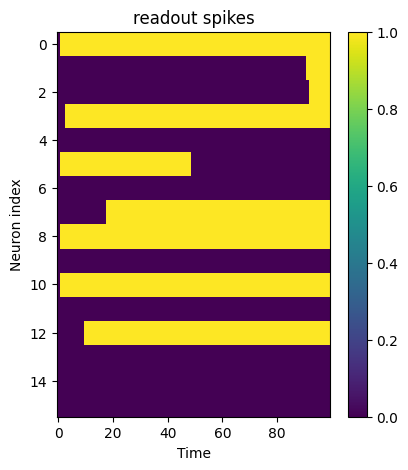

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.subplot(131), plt.imshow(np.array(out).T, aspect='auto', interpolation='none'); plt.title('readout spikes'); plt.xlabel('Time'); plt.ylabel('Neuron index'); plt.colorbar()